# Kopis Internal Data EDA

## Install Necessary Libraries & Ignore Warnings

In [1]:
!pip install openpyxl
!pip install seaborn
!pip install xgboost

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

> * 한글 폰트 설정

In [3]:
import matplotlib.font_manager as fm
fm.findSystemFonts()

['/System/Library/Fonts/Supplemental/Savoye LET.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansTakri-Regular.ttf',
 '/System/Library/Fonts/Supplemental/NotoSansYi-Regular.ttf',
 '/System/Library/Fonts/Supplemental/NotoSansSoraSompeng-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Gurmukhi Sangam MN.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansKaithi-Regular.ttf',
 '/System/Library/Fonts/Supplemental/NotoSansMahajani-Regular.ttf',
 '/System/Library/Fonts/Supplemental/NotoSansRejang-Regular.ttf',
 '/System/Library/Fonts/Supplemental/NotoSansTaiViet-Regular.ttf',
 '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/28f00a24ba19995bab7249993e6e35d11011074a.asset/AssetData/Kai.ttf',
 '/System/Library/Fonts/Supplemental/Sathu.ttf',
 '/System/Library/Fonts/Supplemental/Wingdings 2.ttf',
 '/System/Library/Fonts/Supplemental/Khmer Sangam MN.ttf',
 '/System/Library/Fonts/Supplemental/Tahoma Bold.ttf',
 '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/b8cf53b3591d6062cd536ba5

In [65]:
# 폰트 경로 설정 (NanumGothic.ttc 사용)
font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bad9b4bf17cf1669dde54184ba4431c22dcad27b.asset/AssetData/NanumGothic.ttc'
fontprop = fm.FontProperties(fname=font_path)

# 폰트 등록
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = fontprop.get_name()

## Read Dataset

> * 주소별로 그룹화해서 공연장을 특정가능, 입장권 고유번호로 특정인의 예매일시와 취소일시 파악 가능?
> * 예매/취소 구분은 1, 2로 표현되고 있음 -> 0: 예매, 1: 취소로 변경
> * 공연코드가 다른 엑셀 파일에서도 동일한지 확인 필요

In [200]:
import pandas as pd
file_path = "/Users/myungjunlee/Desktop/Kopis/(데이터) 23년(240524)/(데이터)_19년 하반기~ _23년 하반기 공모전 raw데이터_2023_01_01_10_852,741.xlsx"
df = pd.read_excel(file_path)

In [201]:
a = df.iloc[150:151].T
print(a.to_string())

                                                                                        150
전송사업자코드                                                                            SE000201
전송사업자명                                                                                 인터파크
공연시설코드                                                                             FC222284
시설특성                                                                              민간(대학로 외)
개관연도                                                                                 2004.0
주소                                                              서울특별시 강남구 테헤란로113길 7 (삼성동) 
편의시설_레스토랑 여부                                                                              N
편의시설_카페 여부                                                                                N
편의시설_편의점 여부                                                                               N
편의시설_놀이방 여부                                                                     

In [202]:
b = df[df['입장권고유번호'] == 'T0900227605'].T
print(b.to_string())

                                                                                        121                                                                        150
전송사업자코드                                                                            SE000201                                                                   SE000201
전송사업자명                                                                                 인터파크                                                                       인터파크
공연시설코드                                                                             FC222284                                                                   FC222284
시설특성                                                                              민간(대학로 외)                                                                  민간(대학로 외)
개관연도                                                                                 2004.0                                                                     2004.

In [203]:
df['예매/취소구분'] = df['예매/취소구분'].replace({1: 0, 2: 1})

In [204]:
# '예매/취소일시'를 datetime으로 변환
df['공연일시'] = pd.to_datetime(df['공연일시'])
# 날짜, 시간, 요일 피처 생성
df['공연날짜'] = df['공연일시'].dt.date  # 날짜
df['공연시간'] = df['공연일시'].dt.hour  # 시간
df['요일'] = df['공연일시'].dt.dayofweek  # 요일 (0: 월요일, 6: 일요일)

In [205]:
c = df[df['공연코드'] == 'PF394750']
print(c.columns)

Index(['전송사업자코드', '전송사업자명', '공연시설코드', '시설특성', '개관연도', '주소', '편의시설_레스토랑 여부',
       '편의시설_카페 여부', '편의시설_편의점 여부', '편의시설_놀이방 여부', '편의시설_수유실 여부',
       '장애인시설_주차장 여부', '장애인시설_화장실 여부', '장애인시설_경사로 여부', '장애인시설_전용엘리베이터 여부',
       '주차시설_자체 여부', '주차시설_공영 여부', '공연장코드', '좌석수', '장애인석', '무대시설_오케스트라피트 여부',
       '무대시설_연습실 여부', '무대시설_분장실 여부', '무대시설_무대넓이', '공연코드', '공연회차', '공연일시',
       '입장권고유번호', '예매/취소일시', '예매/취소구분', '예매/취소매수', '예매/취소금액', '예매/취소방식코드',
       '예매/취소방식명(관리시스템)', '예매/취소방식명(전송처)', '결제수단코드', '결제수단명(관리시스템)',
       '결제수단명(전송처)', '할인금액', '할인종류코드', '할인종류명(관리시스템)', '할인종류명(전송처)', '장당금액',
       '성별', '연령', '공연시작일자', '공연종료일자', '소요시간', '장르명', '세부장르명', '공연지역명',
       '출연진내용', '제작진내용', '기획제작사명', '원작자명', '극작가명', '수상실적', '관람연령', '아동공연 여부',
       '축제 여부', '내한공연 여부', '오픈런 여부', '판매시작일시', '판매종료일시', '좌석등급', '단독판매여부',
       '판매좌석수', '판매페이지URL', '공연날짜', '공연시간', '요일'],
      dtype='object')


In [206]:
# 공연코드별로 공연일자의 고유 개수 계산
unique_dates_per_performance = df.groupby('공연코드')['공연일시'].nunique()

# 공연일자가 가장 많은 공연코드 찾기
max_dates_performance_code = unique_dates_per_performance.idxmax()
max_dates_count = unique_dates_per_performance.max()

# 결과 출력
print(f"공연일자가 가장 많은 공연코드: {max_dates_performance_code}")
print(f"공연일수: {max_dates_count}")

공연일자가 가장 많은 공연코드: PF394750
공연일수: 41


In [271]:
# 특정 공연코드(PF394750)에 해당하는 데이터 필터링
pf394750_df = df[df['공연코드'] == 'PF394750']
# 공연일자별로 예매/취소 집계
reservation_cancellation_summary = pf394750_df.groupby(['공연일시', '예매/취소구분'])['예매/취소매수'].size().unstack(fill_value=0)
# 컬럼명 변경 (0: 예매, 1: 취소)
reservation_cancellation_summary.columns = ['예매수', '취소수']
# 최종 예약수 계산 (예매수 - 취소수)
reservation_cancellation_summary['최종 예약수'] = reservation_cancellation_summary['예매수'] - reservation_cancellation_summary['취소수']
# 좌석수는 동일하다고 가정하고 첫 번째 좌석수를 가져옴
seat_count = pf394750_df['좌석수'].iloc[0]
reservation_cancellation_summary['남은 좌석수'] = seat_count - reservation_cancellation_summary['최종 예약수']
reservation_cancellation_summary['남은 좌석수'] = reservation_cancellation_summary['남은 좌석수'].apply(lambda x: max(x, 0))
# 결과 출력
print(reservation_cancellation_summary)

                     예매수  취소수  최종 예약수  남은 좌석수
공연일시                                         
2023-01-01 13:00:00   45   11      34      76
2023-01-01 15:10:00  121   15     106       4
2023-01-01 17:20:00   64    2      62      48
2023-01-01 19:30:00   37    2      35      75
2023-01-02 13:00:00    2    2       0     110
2023-01-02 15:10:00   58    6      52      58
2023-01-02 17:20:00   39    6      33      77
2023-01-02 19:30:00   19    2      17      93
2023-01-03 13:00:00   20    3      17      93
2023-01-03 15:10:00   83    7      76      34
2023-01-03 17:20:00   24    6      18      92
2023-01-03 19:30:00   32    0      32      78
2023-01-04 13:00:00   22    0      22      88
2023-01-04 15:10:00   53    4      49      61
2023-01-04 17:20:00   28    2      26      84
2023-01-04 19:30:00   10    0      10     100
2023-01-05 13:00:00   39    6      33      77
2023-01-05 15:10:00   62    2      60      50
2023-01-05 17:20:00   36    0      36      74
2023-01-05 19:30:00   22    4     

In [272]:
pf394750_df.columns

Index(['전송사업자코드', '전송사업자명', '공연시설코드', '시설특성', '개관연도', '주소', '편의시설_레스토랑 여부',
       '편의시설_카페 여부', '편의시설_편의점 여부', '편의시설_놀이방 여부', '편의시설_수유실 여부',
       '장애인시설_주차장 여부', '장애인시설_화장실 여부', '장애인시설_경사로 여부', '장애인시설_전용엘리베이터 여부',
       '주차시설_자체 여부', '주차시설_공영 여부', '공연장코드', '좌석수', '장애인석', '무대시설_오케스트라피트 여부',
       '무대시설_연습실 여부', '무대시설_분장실 여부', '무대시설_무대넓이', '공연코드', '공연회차', '공연일시',
       '입장권고유번호', '예매/취소일시', '예매/취소구분', '예매/취소매수', '예매/취소금액', '예매/취소방식코드',
       '예매/취소방식명(관리시스템)', '예매/취소방식명(전송처)', '결제수단코드', '결제수단명(관리시스템)',
       '결제수단명(전송처)', '할인금액', '할인종류코드', '할인종류명(관리시스템)', '할인종류명(전송처)', '장당금액',
       '성별', '연령', '공연시작일자', '공연종료일자', '소요시간', '장르명', '세부장르명', '공연지역명',
       '출연진내용', '제작진내용', '기획제작사명', '원작자명', '극작가명', '수상실적', '관람연령', '아동공연 여부',
       '축제 여부', '내한공연 여부', '오픈런 여부', '판매시작일시', '판매종료일시', '좌석등급', '단독판매여부',
       '판매좌석수', '판매페이지URL', '공연날짜', '공연시간', '요일'],
      dtype='object')

## Cleaning Data
> * 직관적으로 관련이 없거나 결측치가 많은 경우 Drop
> * 취소율과 직접적으로 관계된 특성은 제거
> * 예매/취소 일시 -> 누가 예매를 했고, 누가 취소를 했는지 특정하기가 힘듬 / 예매일시와 취소일시를 파악할 수 있는지 확인 필요
> * 주소별로 df를 나누고(groupby) 주소별 취소율을 예측해보자

In [273]:
# 결측치 확인
pf_isnull = pf394750_df.columns[pf394750_df.isnull().any()].tolist()
unique_counts = pf394750_df.nunique()
pf_same = unique_counts[unique_counts == 1].index.tolist()
columns_to_drop = pf_isnull + pf_same
columns_to_drop

['개관연도',
 '무대시설_무대넓이',
 '할인종류명(전송처)',
 '원작자명',
 '극작가명',
 '수상실적',
 '판매좌석수',
 '공연시설코드',
 '시설특성',
 '주소',
 '편의시설_레스토랑 여부',
 '편의시설_카페 여부',
 '편의시설_편의점 여부',
 '편의시설_놀이방 여부',
 '편의시설_수유실 여부',
 '장애인시설_주차장 여부',
 '장애인시설_화장실 여부',
 '장애인시설_경사로 여부',
 '장애인시설_전용엘리베이터 여부',
 '주차시설_자체 여부',
 '주차시설_공영 여부',
 '공연장코드',
 '좌석수',
 '장애인석',
 '무대시설_오케스트라피트 여부',
 '무대시설_연습실 여부',
 '무대시설_분장실 여부',
 '공연코드',
 '공연회차',
 '예매/취소매수',
 '공연시작일자',
 '공연종료일자',
 '소요시간',
 '장르명',
 '세부장르명',
 '공연지역명',
 '출연진내용',
 '제작진내용',
 '기획제작사명',
 '관람연령',
 '아동공연 여부',
 '축제 여부',
 '내한공연 여부',
 '오픈런 여부',
 '좌석등급',
 '단독판매여부']

In [274]:
df_cleaned = pf394750_df.drop(columns=columns_to_drop)

In [275]:
df_cleaned = df_cleaned.drop(['전송사업자코드', '예매/취소일시','예매/취소금액','예매/취소방식코드','예매/취소방식명(관리시스템)', 
                              '예매/취소방식명(전송처)', '결제수단코드','결제수단명(관리시스템)', '할인종류코드', '판매시작일시',
                              '판매종료일시', '판매페이지URL', '공연일시', '입장권고유번호'], axis=1)

In [276]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2597 entries, 5294 to 844981
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   전송사업자명        2597 non-null   object
 1   예매/취소구분       2597 non-null   int64 
 2   결제수단명(전송처)    2597 non-null   object
 3   할인금액          2597 non-null   int64 
 4   할인종류명(관리시스템)  2597 non-null   object
 5   장당금액          2597 non-null   int64 
 6   성별            2597 non-null   int64 
 7   연령            2597 non-null   int64 
 8   공연날짜          2597 non-null   object
 9   공연시간          2597 non-null   int32 
 10  요일            2597 non-null   int32 
dtypes: int32(2), int64(5), object(4)
memory usage: 223.2+ KB


## Summary Statistics for Dataset

In [277]:
df_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
예매/취소구분,2597.0,0.089719,0.285834,0.0,0.0,0.0,0.0,1.0
할인금액,2597.0,6465.163650,13021.056761,0.0,0.0,0.0,0.0,36100.0
장당금액,2597.0,24189.526377,13165.411375,100.0,15900.0,19900.0,19900.0,50000.0
성별,2597.0,1.128995,0.795739,0.0,0.0,1.0,2.0,2.0
연령,2597.0,1495.840585,864.486795,0.0,0.0,1995.0,2000.0,2007.0
공연시간,2597.0,15.824028,1.994849,11.0,15.0,15.0,17.0,20.0
요일,2597.0,3.615325,2.268454,0.0,1.0,5.0,6.0,6.0


In [278]:
df_cleaned.describe(include='object').T

,count,unique,top,freq
전송사업자명,2597,9,네이버N예약,1314
결제수단명(전송처),2597,30,기타,1147
할인종류명(관리시스템),2597,2,기타,2591
공연날짜,2597,10,2023-01-07,607


## Data Preprocessing

> * 관계없는 정보를 가진 특성 제거
> * Feature 엔지니어링 작업 및 높은 카디널리티 특성 제거
> * object type은 one-hot encoding

In [279]:
# object 타입의 컬럼 선택
object_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()
object_columns

['전송사업자명', '결제수단명(전송처)', '할인종류명(관리시스템)', '공연날짜']

In [280]:
# one-hot 인코딩 수행
df_encoded = pd.get_dummies(df_cleaned, columns=object_columns, drop_first=True)

In [281]:
len(df_encoded)

2597

In [282]:
print(df_encoded.shape)
print(df_encoded.columns)

(2597, 54)
Index(['예매/취소구분', '할인금액', '장당금액', '성별', '연령', '공연시간', '요일', '전송사업자명_예스24',
       '전송사업자명_위메프', '전송사업자명_인터파크', '전송사업자명_쿠팡', '전송사업자명_클립서비스', '전송사업자명_타임티켓',
       '전송사업자명_티몬', '전송사업자명_티켓링크', '결제수단명(전송처)_간편결제 PAYCO',
       '결제수단명(전송처)_간편결제 TOSS', '결제수단명(전송처)_기타', '결제수단명(전송처)_네이버페이',
       '결제수단명(전송처)_다중결제', '결제수단명(전송처)_로켓 밸런스', '결제수단명(전송처)_로켓 뱅크',
       '결제수단명(전송처)_로켓 카드', '결제수단명(전송처)_무통장', '결제수단명(전송처)_무통장 입금',
       '결제수단명(전송처)_무통장입금', '결제수단명(전송처)_신용카드', '결제수단명(전송처)_신용카드 간편결제',
       '결제수단명(전송처)_이제너두', '결제수단명(전송처)_인터파크페이(계좌)', '결제수단명(전송처)_인터파크페이(카드)',
       '결제수단명(전송처)_카드', '결제수단명(전송처)_카드결제', '결제수단명(전송처)_카카오페이',
       '결제수단명(전송처)_카카오페이(카드)', '결제수단명(전송처)_카카오페이(카카오머니)',
       '결제수단명(전송처)_쿠팡캐시,로켓 뱅크', '결제수단명(전송처)_쿠팡캐시,로켓 카드', '결제수단명(전송처)_핸드폰',
       '결제수단명(전송처)_핸드폰,쿠팡캐시', '결제수단명(전송처)_현금', '결제수단명(전송처)_현대이지웰포인트',
       '결제수단명(전송처)_휴대폰 결제', '결제수단명(전송처)_휴대폰결제', '할인종류명(관리시스템)_자체할인',
       '공연날짜_2023-01-02', '공연날짜_2023-01-03', '공연날짜_2023-01-04',
       '공연날짜_2023-01-05', '공

## Split the Dataset

In [283]:
X = df_encoded.drop(columns=['예매/취소구분'])
y = df_encoded['예매/취소구분']

In [284]:
from sklearn.model_selection import train_test_split
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## DT Base Model Definition

In [300]:
from sklearn.tree import DecisionTreeClassifier
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

> * DT Hyperparameter Tuning

In [301]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [302]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [303]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [304]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3}


> * DT Model Evaluation

In [305]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [306]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1891
           1       0.47      0.87      0.61       186

    accuracy                           0.90      2077
   macro avg       0.73      0.88      0.78      2077
weighted avg       0.94      0.90      0.91      2077


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       473
           1       0.32      0.64      0.43        47

    accuracy                           0.85       520
   macro avg       0.64      0.75      0.67       520
weighted avg       0.90      0.85      0.87       520



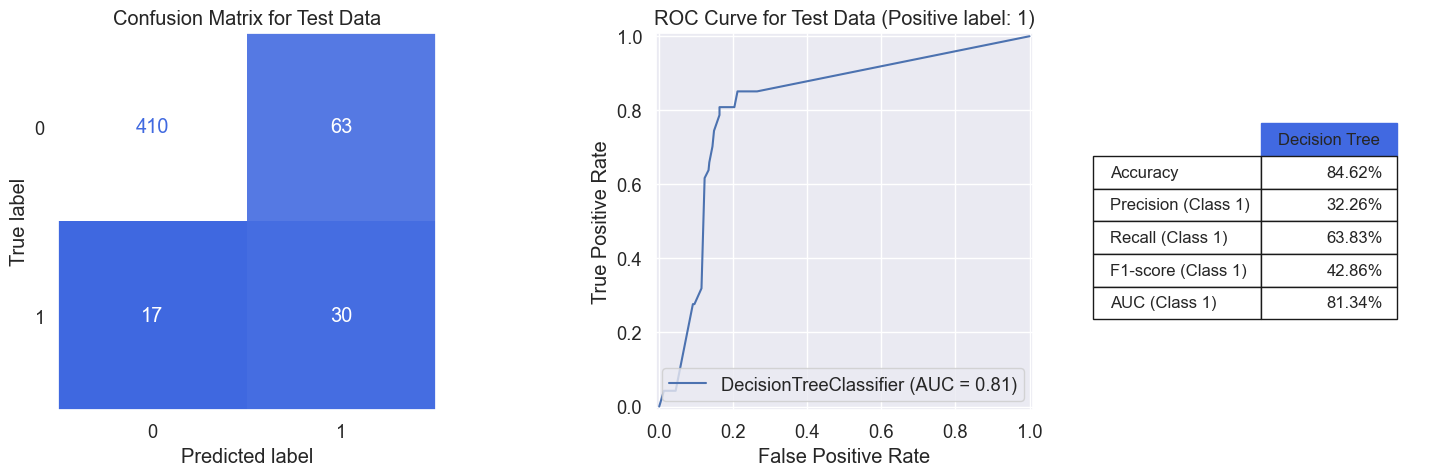

In [307]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

In [308]:
# Save the final performance of DT classifier
dt_result = metrics_calculator(best_dt, X_test, y_test, 'Decision Tree')
dt_result

,Decision Tree
Accuracy,84.62%
Precision (Class 1),32.26%
Recall (Class 1),63.83%
F1-score (Class 1),42.86%
AUC (Class 1),81.34%


## Desicion Tree Feature Importance

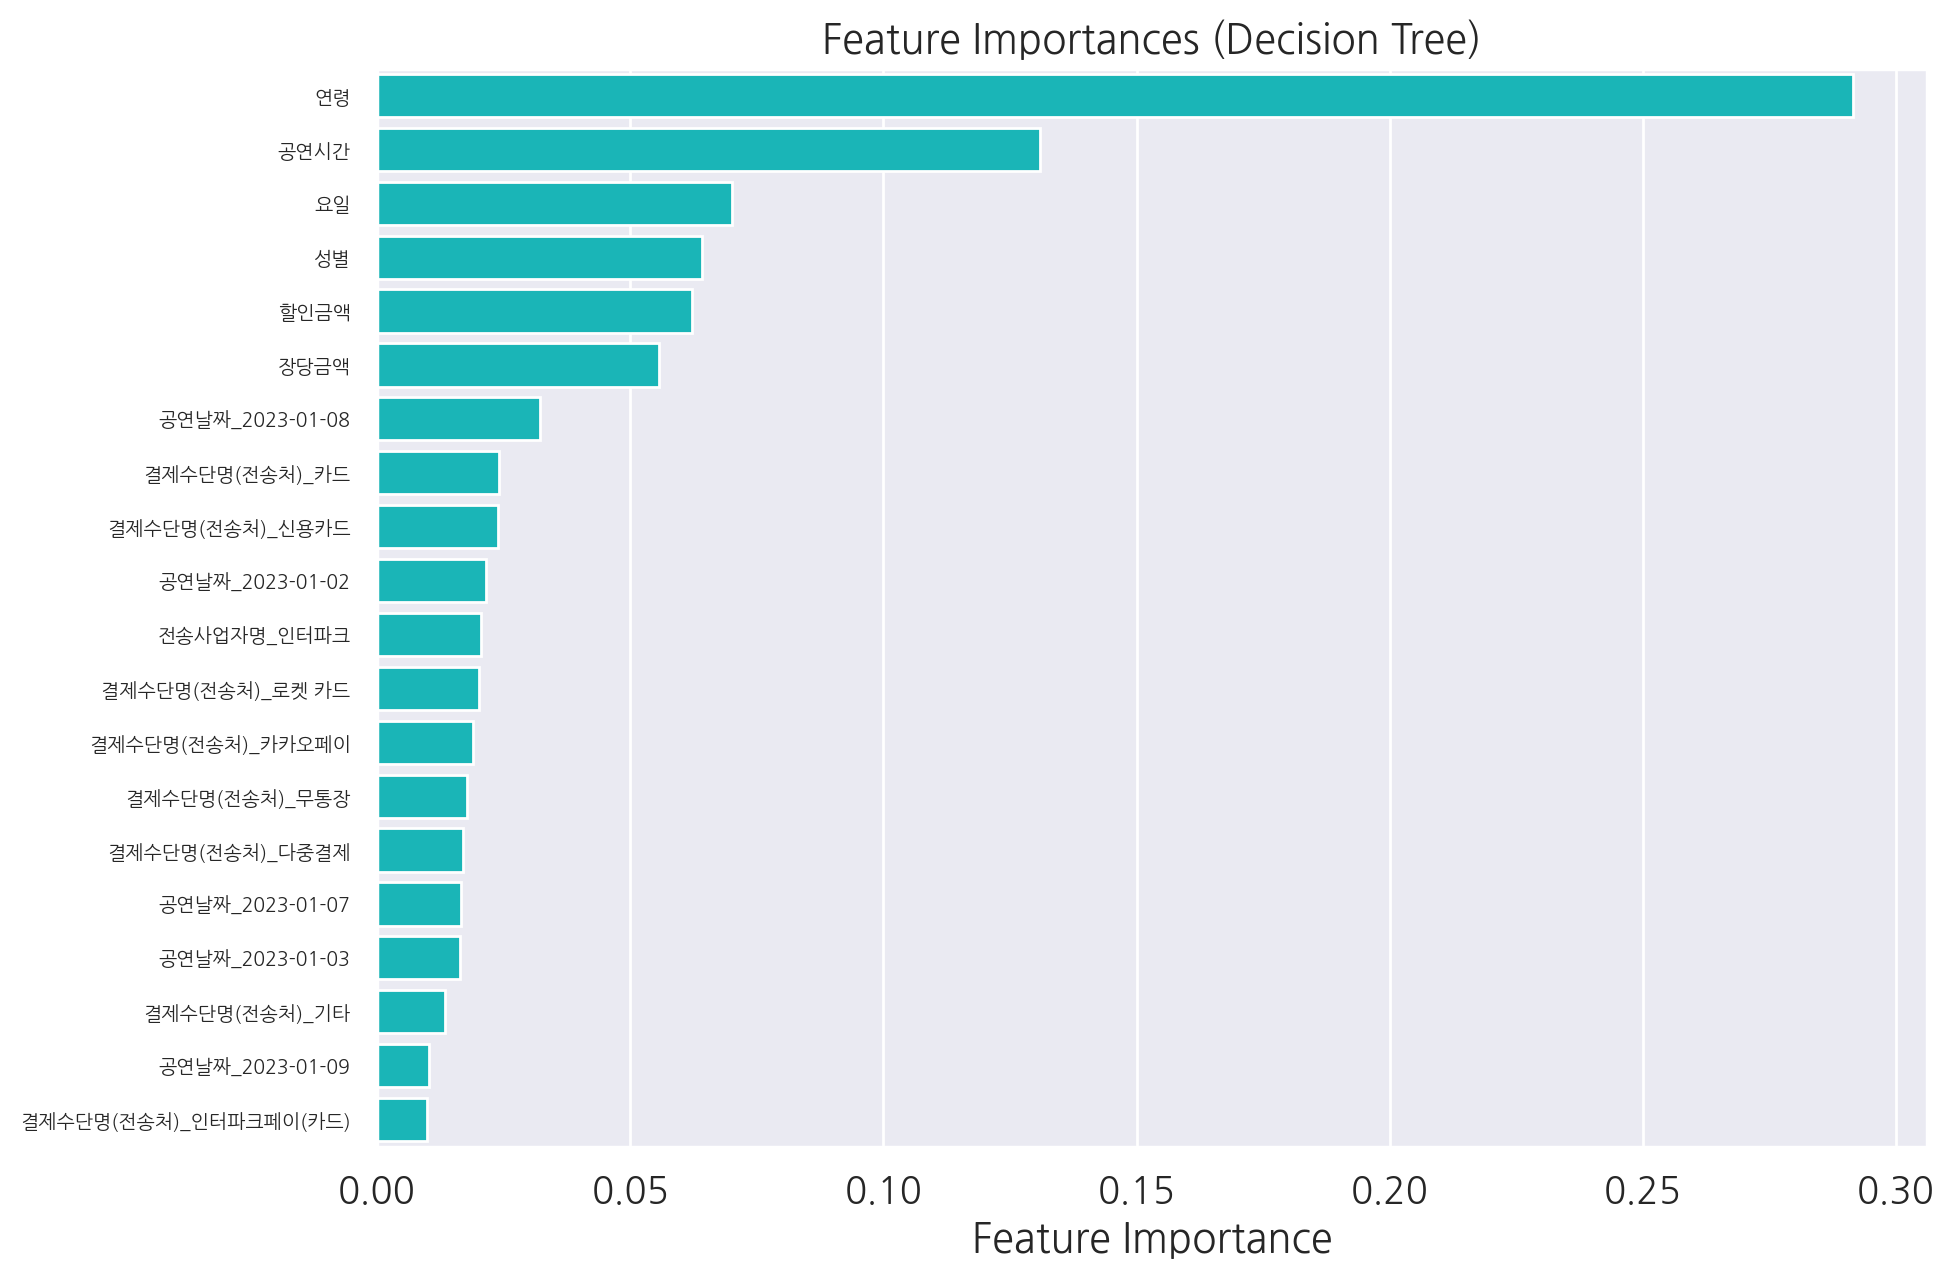

In [309]:
plt.rcParams['font.family'] = fontprop.get_name()

# 피처 중요도 추출
feature_importances_dt = best_dt.feature_importances_

# 중요도 높은 상위 20개의 피처만 선택
sorted_indices_dt = np.argsort(feature_importances_dt)[::-1]
top_n = 20
top_indices_dt = sorted_indices_dt[:top_n]

# 피처 중요도 시각화
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances_dt[top_indices_dt], y=[X.columns[i] for i in top_indices_dt], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Decision Tree)')
plt.yticks(fontsize=7)
plt.show()

## Random Forest Model Building

In [310]:
# Define the base RF model
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

In [311]:
param_grid_rf = {
    'n_estimators': [100, 150],
    'criterion': ['entropy'],
    'max_depth': [16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [312]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)

In [315]:
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1891
           1       0.53      0.66      0.58       186

    accuracy                           0.92      2077
   macro avg       0.75      0.80      0.77      2077
weighted avg       0.93      0.92      0.92      2077


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       473
           1       0.24      0.21      0.22        47

    accuracy                           0.87       520
   macro avg       0.58      0.57      0.58       520
weighted avg       0.86      0.87      0.86       520



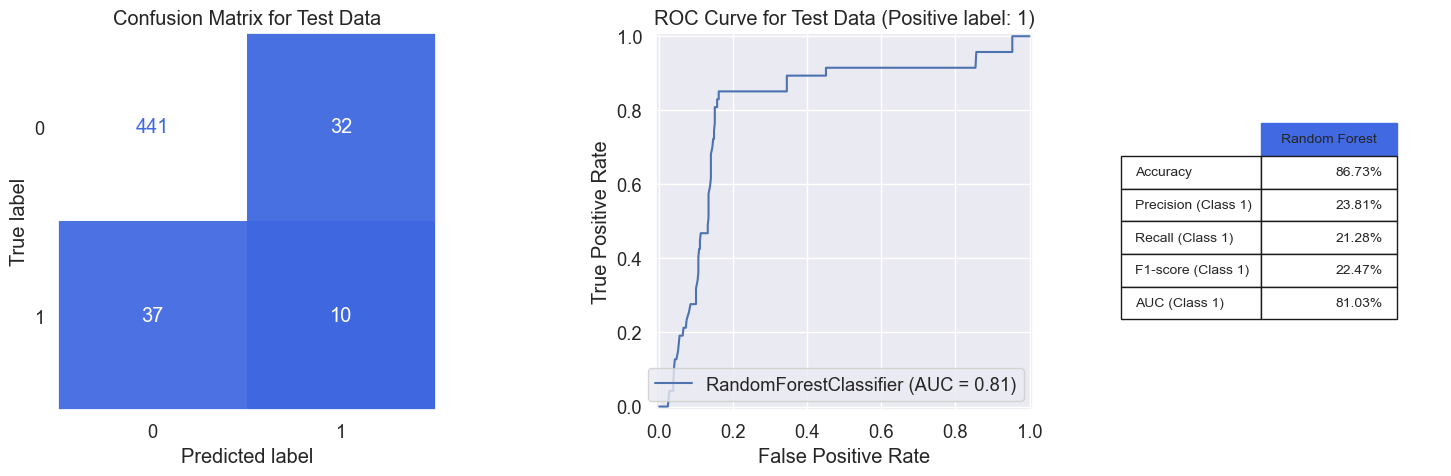

In [316]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

In [317]:
# Save the final performance of RF classifier
rf_result = metrics_calculator(best_rf, X_test, y_test, 'Random Forest')
rf_result

,Random Forest
Accuracy,86.73%
Precision (Class 1),23.81%
Recall (Class 1),21.28%
F1-score (Class 1),22.47%
AUC (Class 1),81.03%


## Random Forest Feature Importance

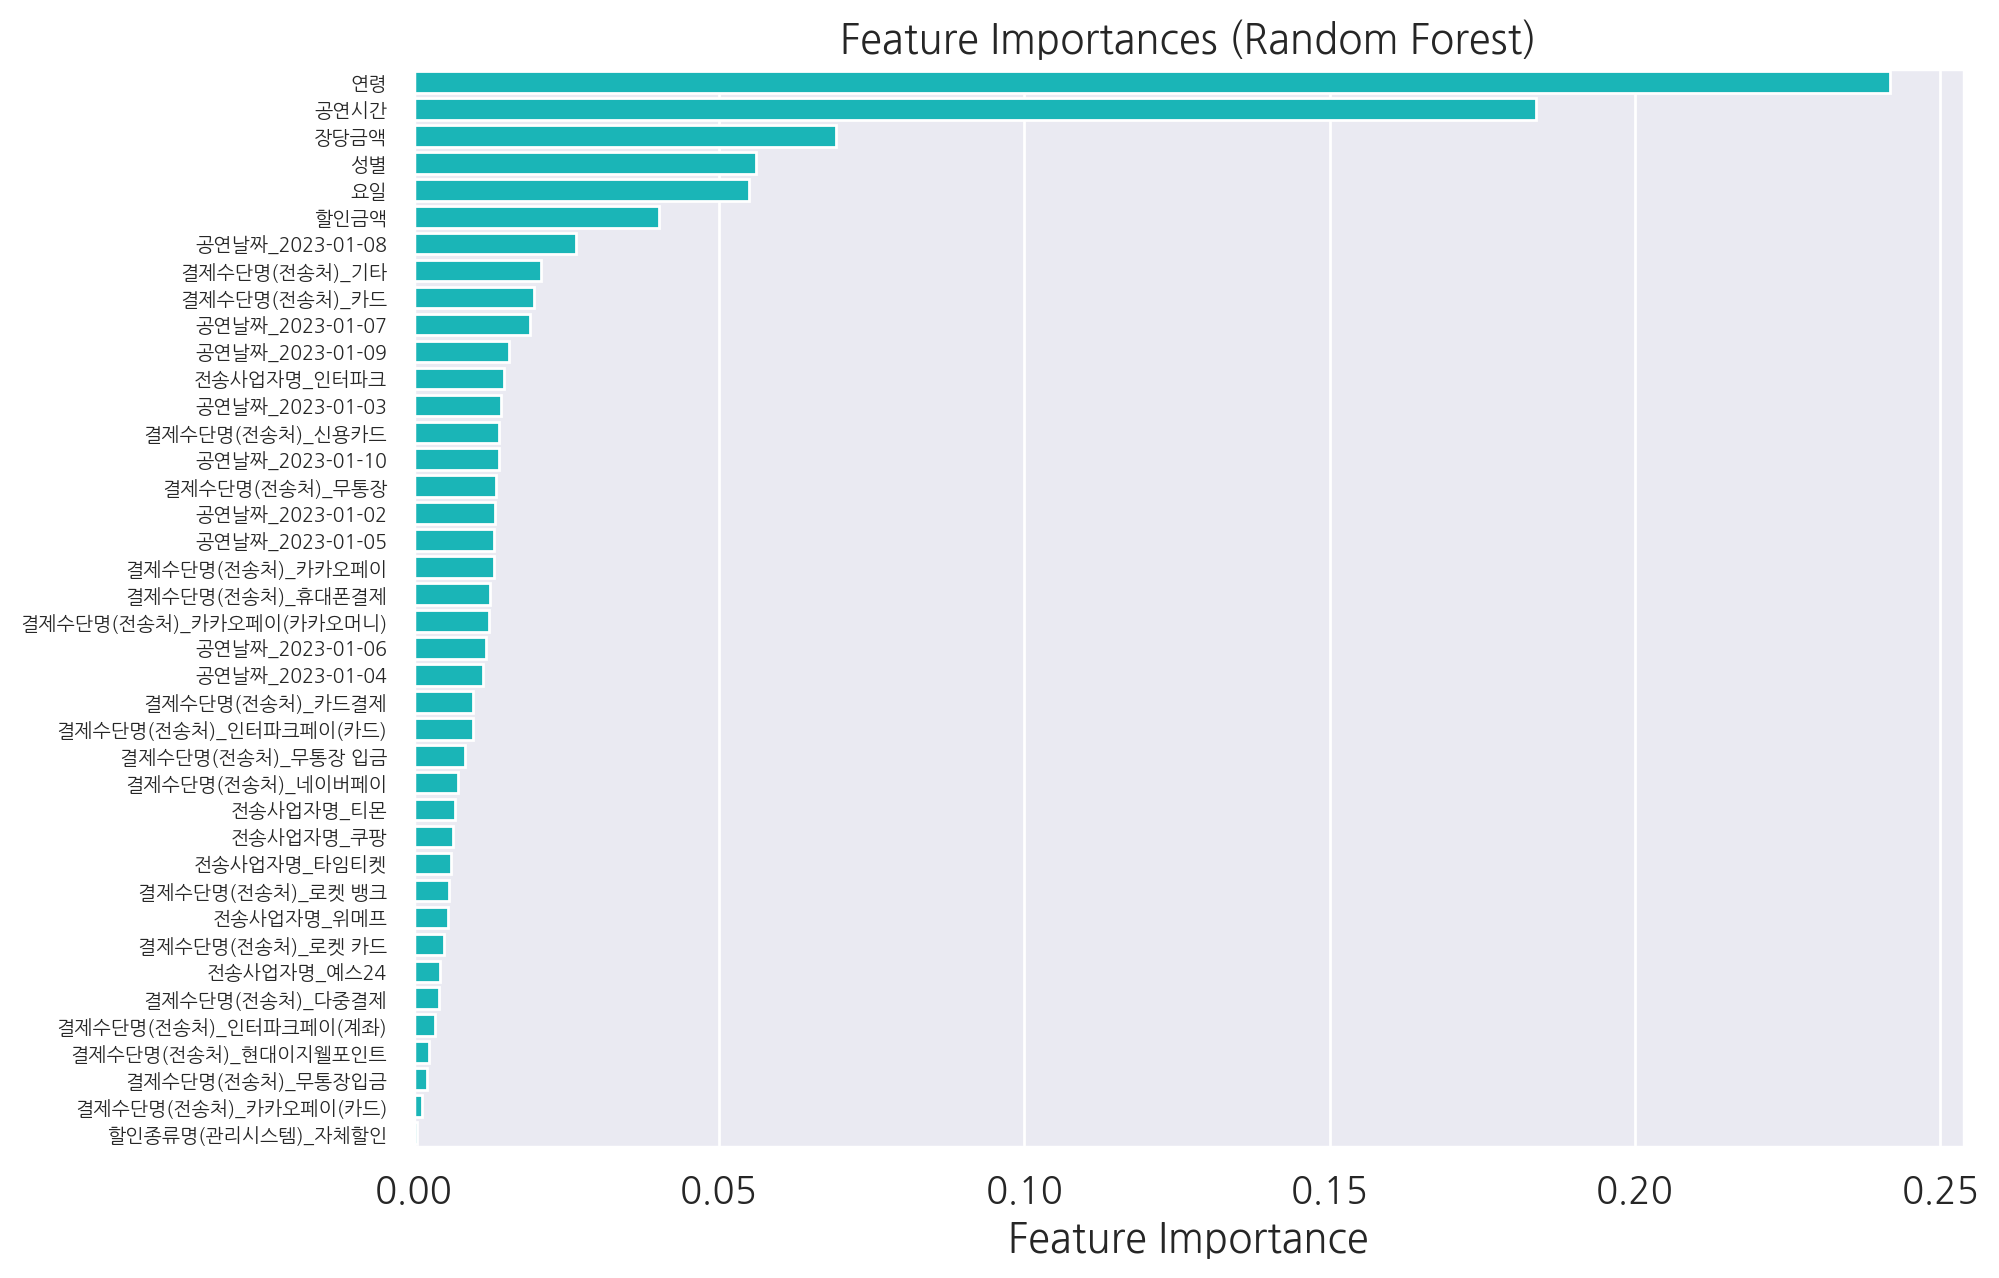

In [318]:
# 피처 중요도 추출
feature_importances = best_rf.feature_importances_

# 중요도 높은 상위 20개의 피처만 선택
sorted_indices = np.argsort(feature_importances)[::-1]
top_n = 40
top_indices = sorted_indices[:top_n]

# 폰트 등록
plt.rcParams['font.family'] = fontprop.get_name()

# 피처 중요도 시각화
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[top_indices], y=[X.columns[i] for i in top_indices], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Random Forest)')
plt.yticks(fontsize=7)
plt.show()

## XGBoost Base Model Definition

In [319]:
# Define the model
xgb_base = xgb.XGBClassifier(eval_metric='logloss', random_state=0)

In [320]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [321]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

In [322]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'scale_pos_weight': 10.166666666666666, 'subsample': 0.8}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1891
           1       0.45      1.00      0.62       186

    accuracy                           0.89      2077
   macro avg       0.73      0.94      0.78      2077
weighted avg       0.95      0.89      0.91      2077


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       473
           1       0.36      0.85      0.50        47

    accuracy                           0.85       520
   macro avg       0.67      0.85      0.71       520
weighted avg       0.93      0.85      0.87       520



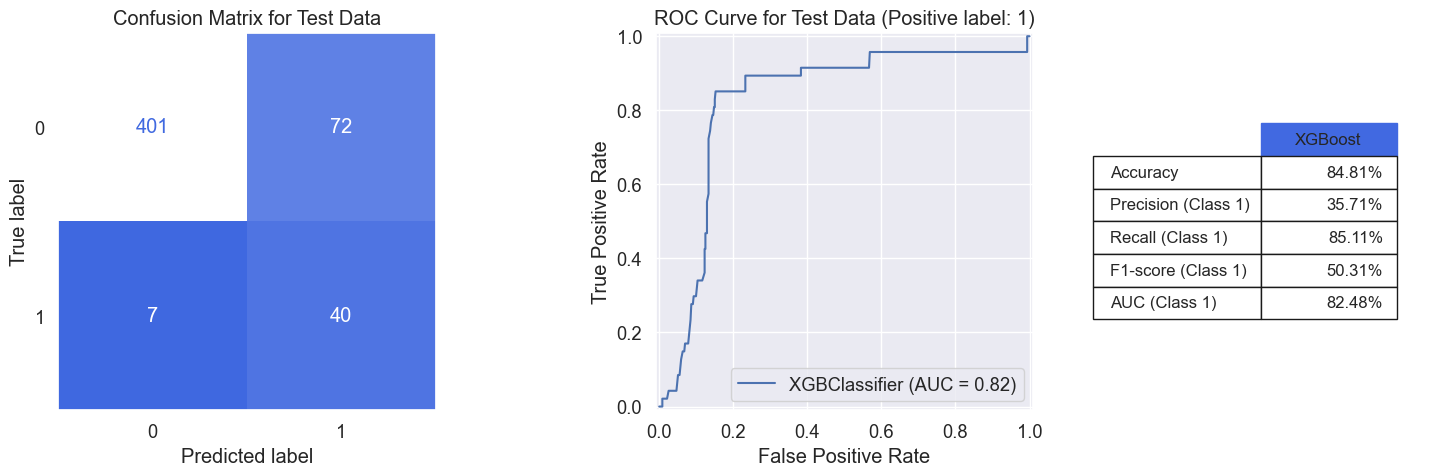

In [323]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [324]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGBoost')
xgb_result

,XGBoost
Accuracy,84.81%
Precision (Class 1),35.71%
Recall (Class 1),85.11%
F1-score (Class 1),50.31%
AUC (Class 1),82.48%


## XGBoost Feature Importance

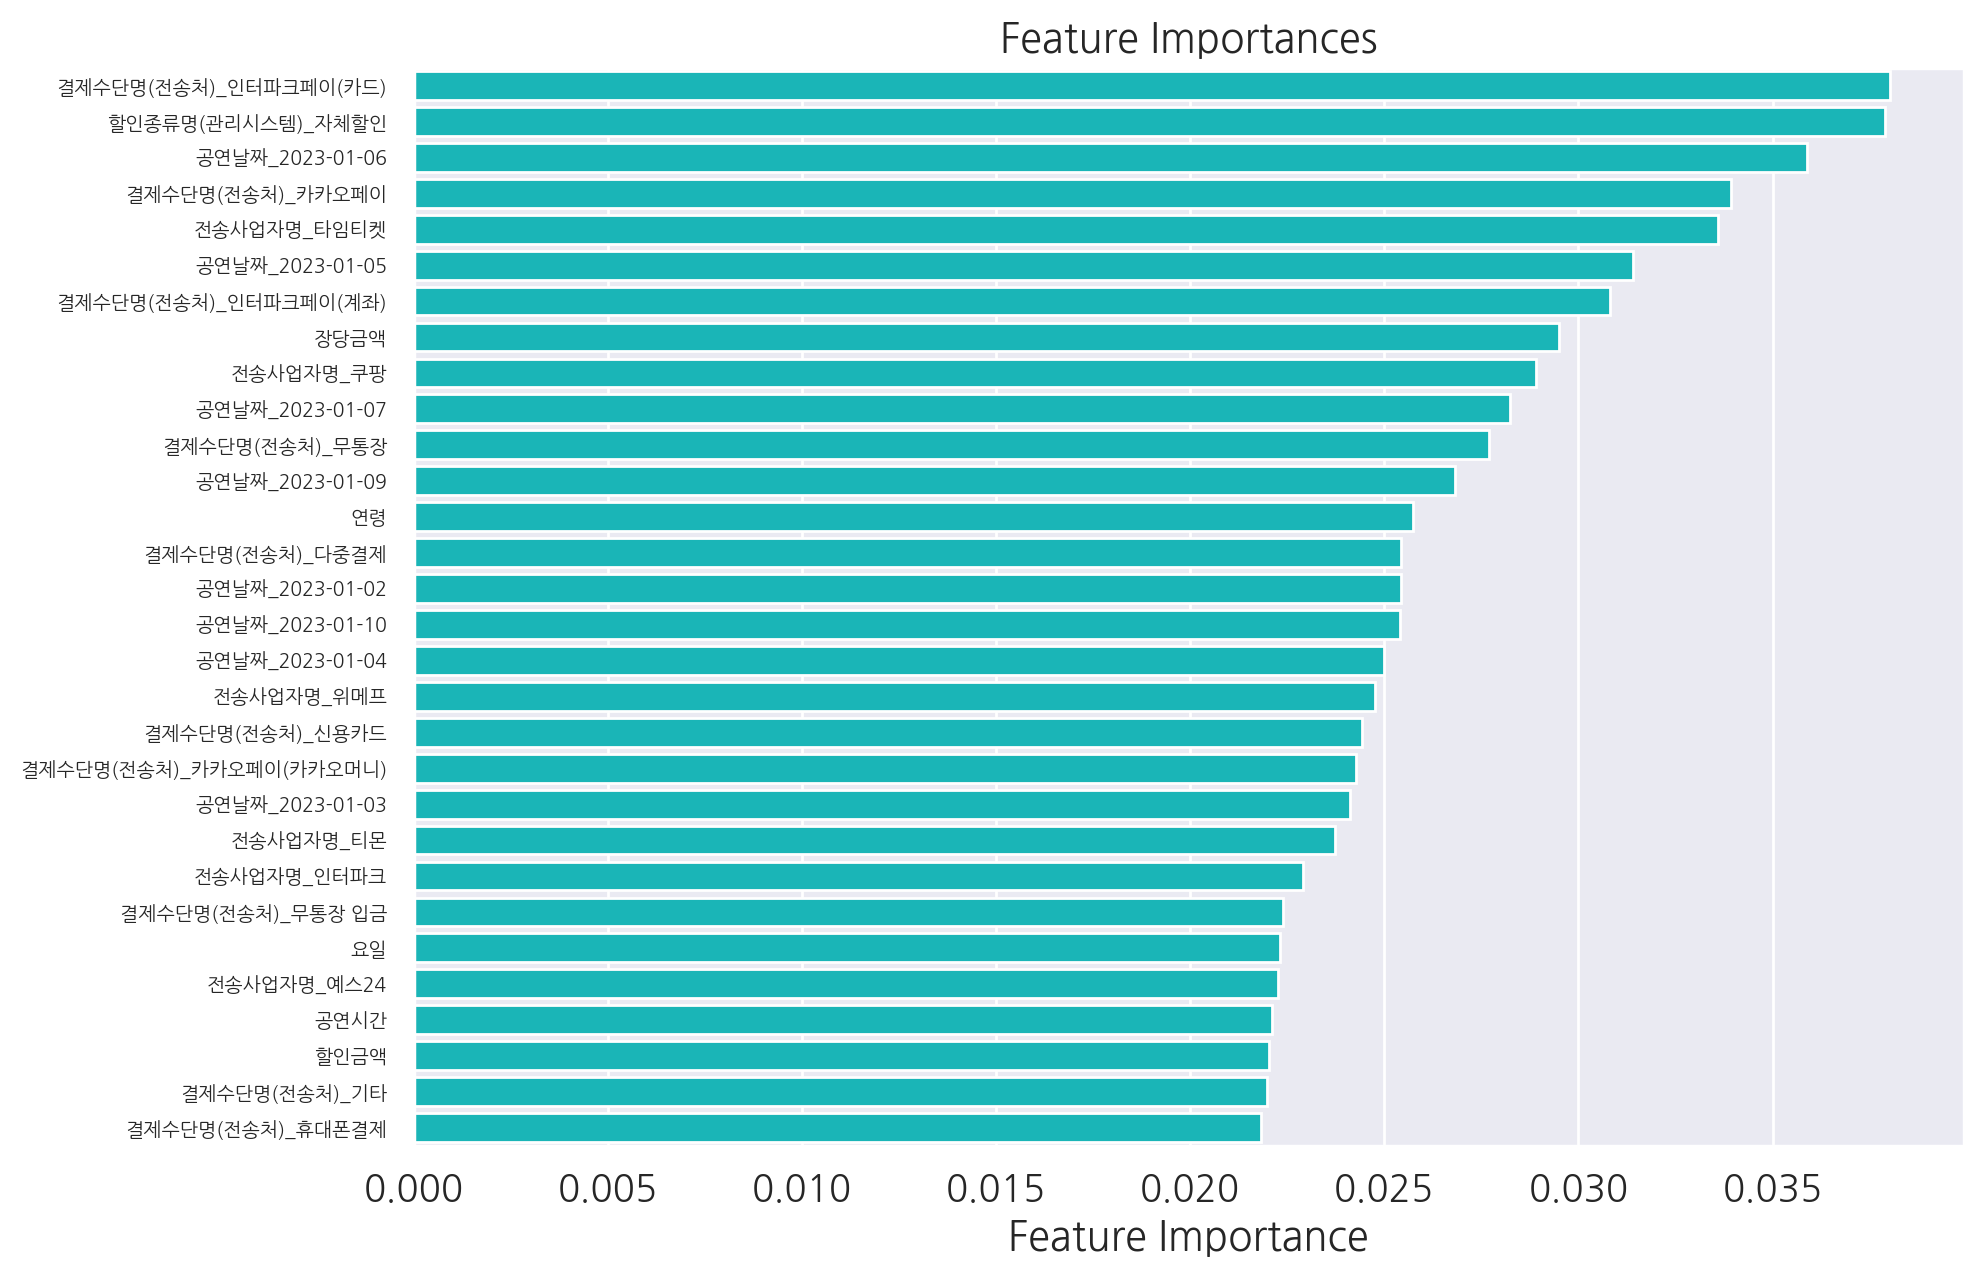

In [325]:
# Compute feature importances
feature_importances = best_xgb.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# 폰트 등록
plt.rcParams['font.family'] = fontprop.get_name()

# 상위 n개의 피처만 선택
top_n = 30
top_indices = sorted_indices[:top_n]

# Plot feature importances
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[top_indices], y=[X.columns[i] for i in top_indices], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

## Conclusion

In [326]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([dt_result, rf_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score (class 1) values
results.sort_values(by='F1-score (Class 1)', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score (Class 1)')

,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1),AUC (Class 1)
XGBoost,84.81%,35.71%,85.11%,50.31%,82.48%
Decision Tree,84.62%,32.26%,63.83%,42.86%,81.34%
Random Forest,86.73%,23.81%,21.28%,22.47%,81.03%


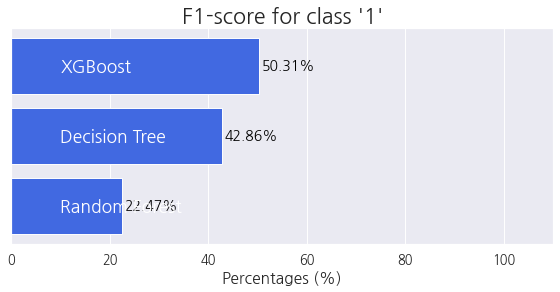

In [327]:
# Prepare values
results.sort_values(by='F1-score (Class 1)', ascending=True, inplace=True)
f1_scores = results['F1-score (Class 1)'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 4), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='black')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

## What feature importance matters

In [328]:
# 피처 중요도 추출
feature_importances_rf = best_rf.feature_importances_
feature_importances_dt = best_dt.feature_importances_
feature_importances_xgb = best_xgb.feature_importances_

# 상위 N개의 피처 선택
top_n = 100
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]
top_features_rf = [X.columns[i] for i in sorted_indices_rf[:top_n]]
top_importances_rf = feature_importances_rf[sorted_indices_rf[:top_n]]

sorted_indices_dt = np.argsort(feature_importances_dt)[::-1]
top_features_dt = [X.columns[i] for i in sorted_indices_dt[:top_n]]
top_importances_dt = feature_importances_dt[sorted_indices_dt[:top_n]]

sorted_indices_xgb = np.argsort(feature_importances_xgb)[::-1]
top_features_xgb = [X.columns[i] for i in sorted_indices_xgb[:top_n]]
top_importances_xgb = feature_importances_xgb[sorted_indices_xgb[:top_n]]

# 결과 데이터프레임 생성
def create_top_features_df(features, importances, model_name):
    return pd.DataFrame({
        'Feature': features,
        f'Importance_{model_name}': importances
    })

rf_top_df = create_top_features_df(top_features_rf, top_importances_rf, 'RF')
dt_top_df = create_top_features_df(top_features_dt, top_importances_dt, 'DT')
xgb_top_df = create_top_features_df(top_features_xgb, top_importances_xgb, 'XGB')

# 데이터프레임 병합
combined_df = pd.merge(rf_top_df, dt_top_df, on='Feature', how='outer')
combined_df = pd.merge(combined_df, xgb_top_df, on='Feature', how='outer')

# NaN 값 0으로 대체 (모델에 없는 피처의 중요도는 0으로 간주)
combined_df.fillna(0, inplace=True)

# 정렬 (랜덤 포레스트 중요도를 기준으로 정렬, 필요에 따라 변경 가능)
combined_df = combined_df.sort_values(by='Importance_RF', ascending=False)
combined_df

,Feature,Importance_RF,Importance_DT,Importance_XGB
40,연령,0.241707,0.291530,0.025740
38,공연시간,0.183860,0.130874,0.022102
42,장당금액,0.069247,0.055725,0.029500
39,성별,0.056139,0.064156,0.018915
41,요일,0.054896,0.070098,0.022308
51,할인금액,0.040156,0.062272,0.022029
35,공연날짜_2023-01-08,0.026685,0.032210,0.019588
2,결제수단명(전송처)_기타,0.020932,0.013478,0.021982
16,결제수단명(전송처)_카드,0.019704,0.024186,0.017882
34,공연날짜_2023-01-07,0.019037,0.016554,0.028233


In [329]:
# 중요도 평균 계산
combined_df['Mean_Importance'] = combined_df[['Importance_RF', 'Importance_DT', 'Importance_XGB']].mean(axis=1)

# 평균 중요도로 정렬
combined_df = combined_df.sort_values(by='Mean_Importance', ascending=False)

In [330]:
graph_df = combined_df.head(20)

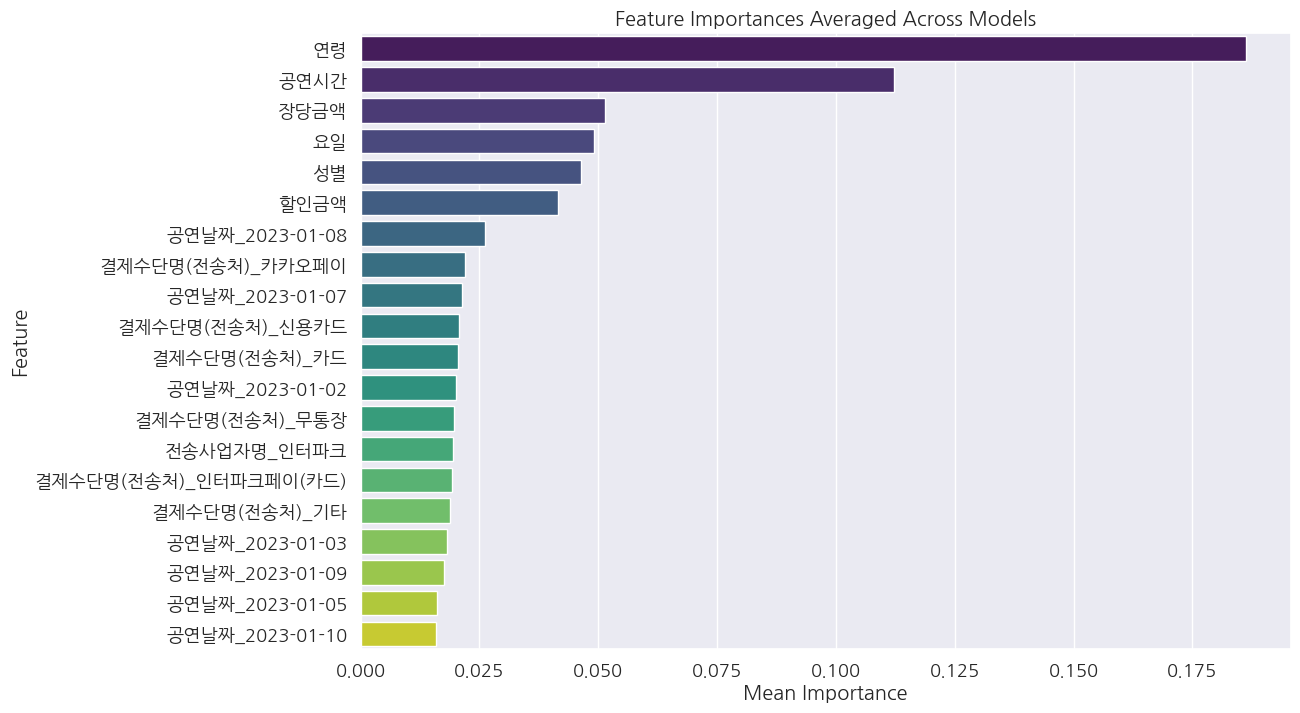

In [331]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean_Importance', y='Feature', data=graph_df, palette='viridis')

# 그래프 설정
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Averaged Across Models')
plt.show()